# Cosine similarities_2
This notebook illustrates how to calculate and display cosine similarities between wordvectors.
As input, we use a file with embeddings generated by [embiggen](https://pypi.org/project/embiggen/]) together
with a file with the corresponding word labels. This notebook  is specifically for the purpose of illustrating the words with highest cosine similatity scores with leukemia and ovarian neopplasms. Also, we illustrate the 3D scatter plot of the top 10 words with highest cos similarity to leukemia and also 10 random words from our corpus.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from scipy.spatial.distance import cosine
from collections import defaultdict
from sklearn.cluster import DBSCAN


The following code allows us to import the ``kcet`` module from the local repository.

In [29]:
import os
import sys
sys.path.insert(0, os.path.abspath('../..'))
from kcet import Wordvec2Cosine

The constructor of ``Wordvec2Cosine`` loads the word embeddings and words into a pandas dataframe.

In [30]:
data_directory = 'data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")
embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto2020.npy")
words_file = os.path.join(data_directory, "words_SG_upto2020.txt")
w2c = Wordvec2Cosine(embeddings=embedding_file, words=words_file)
df = w2c.get_embeddings()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,2.892186,-4.601290,1.886768,3.363972,5.323241,2.037415,-4.547163,2.887746,0.078090,-6.857232,...,-2.348537,4.792399,3.246019,-3.045483,-4.771703,6.965374,-1.852824,0.788342,0.692204,8.816134
patient,3.030980,-4.654769,1.988458,3.286587,4.494266,4.335152,-3.879949,1.414752,0.948940,-4.057512,...,-1.655231,5.274243,5.277645,-1.659015,-4.128818,5.872729,-3.746760,1.387476,-0.132648,8.704845
meshd009369,3.125736,-5.037050,1.834232,3.044192,4.652200,3.345147,-2.471191,2.407151,0.459735,-5.215952,...,-1.343417,3.949077,5.909581,-3.753628,-5.255637,6.504014,-3.489765,1.265763,0.166798,9.207653
0,3.207781,-5.854365,2.169951,2.806666,3.704714,4.489932,-3.641227,2.849144,1.368201,-5.305769,...,-1.802601,4.349891,5.042999,-1.330444,-3.057492,6.769782,-4.191097,0.704711,0.271818,7.927824
study,3.093263,-3.081187,1.896351,3.586287,3.835986,3.025896,-3.602392,3.394049,0.388296,-4.770427,...,-1.487065,4.371748,4.851753,-3.033936,-4.145646,6.956510,-3.810457,0.859616,0.380740,8.665388


## Get the MeSH terms that descend from Lung neoplasms

In [31]:
lung_neo_descendants = pd.read_csv("data/LungNeoplasms.tsv", sep = "\t")["MeSH descriptor"].tolist()
meshd_lung_neo = []
for mesh_desciptor in lung_neo_descendants:
    meshd = "meshd" + mesh_desciptor[1:]
    meshd_lung_neo.append(meshd)
    #print(meshd)

In [32]:
terms_lung_neo = []
for term in meshd_lung_neo:
    if term in df.index:
        terms_lung_neo.append(term)
    
lung_neo_descendant_df = df.loc[terms_lung_neo]
lung_neo_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd008175,3.301751,-4.811779,1.622228,3.851357,2.915498,3.848569,-1.740700,3.183929,0.596785,-5.987088,...,-2.284585,2.975377,5.520432,-2.285758,-3.951332,4.657407,-2.712857,2.580101,0.411148,8.063503
meshd000077192,2.997698,-3.973783,1.934827,3.786742,3.882792,2.959357,-3.569564,3.366140,0.440438,-5.279186,...,-2.126046,3.113032,4.836854,-1.511266,-4.918917,4.884159,-2.259126,2.374165,0.852736,8.293936
meshd002282,2.848512,-4.879909,1.697816,2.488158,2.931847,3.718457,-3.378844,2.231766,-0.157493,-5.216762,...,-1.753302,3.810427,3.903719,-1.857803,-2.950452,4.999865,-2.031033,1.436844,0.751334,8.629610
meshd001984,2.519319,-4.371069,1.705905,2.400935,2.940546,3.295285,-2.396487,1.487975,0.182894,-3.873713,...,-1.255919,3.557224,3.611812,-1.619412,-3.240314,4.556928,-2.965185,1.523867,0.663890,6.811733
meshd002283,3.088353,-4.984658,1.933589,4.056807,4.116179,4.154083,-2.441550,1.894567,0.454660,-5.440371,...,-2.264604,3.463539,5.413669,-1.648129,-3.218199,4.859321,-3.000702,2.721330,0.339338,8.232040


In [33]:
color_lung = ["blue"]#change the color if yo want to differentiate between this 
for i in range(len(terms_lung_neo)-1):
    color_lung.append("blue")

## Get the MeSH terms that descend from ovarian neoplasms

In [34]:
ovarian_descendants = pd.read_csv("data/ovarianNeoplasms.tsv", sep = "\t")["MeSH descriptor"].tolist()
meshd_ovarian = []
for mesh_desciptor in ovarian_descendants:
    meshd = "meshd" + mesh_desciptor[1:]
    meshd_ovarian.append(meshd)
    #print(meshd)

In [35]:
terms_ovarian = []
for term in meshd_ovarian:
    if term in df.index:
        terms_ovarian.append(term)
    
ovarian_descendant_df = df.loc[terms_ovarian]
ovarian_descendant_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
meshd010051,3.072791,-2.909225,2.060097,4.283984,5.044001,3.521364,-2.625771,2.760182,0.359268,-5.208926,...,-2.067533,4.287587,5.239411,-2.756318,-4.954819,6.051542,-4.532008,0.841578,0.163029,7.852741
meshd000077216,2.953218,-2.924506,2.235753,3.520408,5.433797,2.701469,-3.294727,2.832772,1.040954,-4.847880,...,-2.014151,3.565517,5.502385,-2.904055,-4.857262,6.737767,-4.803393,1.434961,0.291188,7.652975
meshd001948,2.114845,-3.445855,1.451699,1.565399,3.261432,3.478113,-2.297478,1.319301,-0.269439,-4.683348,...,-1.149413,3.438398,3.891533,-1.993584,-2.719943,3.982745,-4.441090,0.150367,0.339359,6.288504
meshd006106,2.453123,-3.225351,2.230294,2.072668,3.829018,3.777840,-2.520633,2.707639,0.578923,-4.629045,...,-1.835440,4.750452,4.482211,-2.425702,-3.002339,4.658401,-4.252470,1.110849,0.992910,7.294141
meshd008539,0.803067,-1.330232,0.654609,1.323322,1.445127,1.163081,-1.423022,0.913188,0.238121,-1.911834,...,-0.472482,1.530111,1.661097,-1.086506,-1.399170,1.991800,-1.244199,0.338743,0.002728,3.760147


In [36]:
color_ovarian = ["green"] #change the color if you want to differentaitate ovarian neoplasms with other points
for i in range(len(terms_ovarian)-1):
    color_ovarian.append("green")

In [37]:
cvec = color_lung + color_ovarian

print(cvec)

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green', 'green']


In [38]:
frames = [lung_neo_descendant_df, ovarian_descendant_df]
lung_ovarian_df = pd.concat(frames)

In [39]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(lung_ovarian_df.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.6817228  0.11548048 0.06351164]


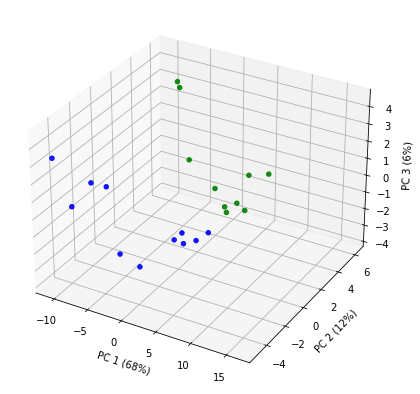

In [42]:
from mpl_toolkits.mplot3d import axes3d, Axes3D
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(pca_result[:,0], pca_result[:,1], pca_result[:,2], color = cvec,alpha=0.9)
#plt.title("3D scatter plot")
ax.set_xlabel('PC 1 (%.f%%)' % (pca.explained_variance_ratio_[0]*100)) 
ax.set_ylabel('PC 2 (%.f%%)' % (pca.explained_variance_ratio_[1]*100)) 
ax.set_zlabel('PC 3 (%.f%%)' % (pca.explained_variance_ratio_[2]*100))
 
# show plot
plt.show()

Text(0, 0.5, 'PC 2 (11.55%)')

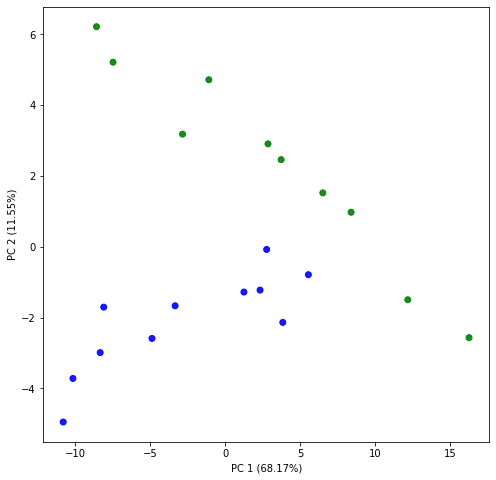

In [41]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0],pca_result[:,1] ,c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

## Get all cosine similarites between lung neoplasms and all words 
We retrieve the top n most similar words. The function ``n_most_similar_words`` returns a list of tuples,
and ``n_most_similar_words_df`` returns a Pandas dataframe.

In [15]:
target_word ='meshd008175' # Lung neoplasms
n=df.shape[0]
all_cosine_similarities_lung_neo = w2c.n_most_similar_words_df(target_word=target_word, n=n)

In [16]:
all_cosine_similarities_lung_neo.head(n=6) #top 5 words which have highest cosine similarity scores between Leukemia and other words

,word,similarity
0,meshd008175,1.000000
1,meshd000077192,0.989391
2,meshd002289,0.986906
3,meshd055752,0.986180
4,meshd002283,0.986085
5,mpm,0.984974


## Get all cosine similarites between ovarian neoplasms and all words 
We retrieve the top n most similar words. The function ``n_most_similar_words`` returns a list of tuples,
and ``n_most_similar_words_df`` returns a Pandas dataframe.

In [ ]:
target_word ='meshd010051' # ovarian neoplasms
n=df.shape[0]
all_cosine_similarities_ovarian_neoplasms = w2c.n_most_similar_words_df(target_word=target_word, n=n)

In [ ]:
all_cosine_similarities_ovarian_neoplasms.head(n=6) #top 5 words which have highest cosine similarity scores between ovarian neoplasms and other words
